## Importing timeseries from uvfits to csv
This is a short instruction of how to import timeseries from uvfits to csv with **timed** library, available here:

https://github.com/wielgusm/timed_new.git

The **timed** library requires eht-imaging library:

https://github.com/achael/eht-imaging.git

Everything is in early development stage:)

**Maciek Wielgus 20/09/2018**

In [2]:
%load_ext autoreload
%autoreload 2
import sys,os, itertools
sys.path.append('/Volumes/DATAPEN/Shared/EHT/TDWG/')
#sys.path.append('/Volumes/DATAPEN/Shared/EHT/EHTIM/eht-imaging_fork/eht-imaging/')
sys.path.append('/Volumes/DATAPEN/Shared/EHT/EHTIM/eht-imaging_polrep/eht-imaging/')
import timed_new
from timed_new import timed_io as timed
#import simulate
import matplotlib.pyplot as plt
import numpy as np
import ehtim as eh
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#some fake simulation data path
path_sim='/Users/mwielgus/Dropbox (Smithsonian External)/Shared/EHT/TDWG/DataGeneration/TD_EHT/data/generated/continuous_diff_periods_vexA/0.1noise/data_10min_1noise_1ratio/data_10.000min_1.00noise_1.00ratio.uvfits'

#some real EHT data path
path_eht= '/Users/mwielgus/Dropbox (Smithsonian External)/Shared/EHT/Data/er4/hops-lo/7.+apriori/3601/hops_3601_3C279.apriori.uvfits'

## Loading uvfits

**timed** works on tobsdata objects which are equivalent to eht-imaging obsdata objects. You can directly load uvfits file or convert eht-imaging obsdata object. There is an option 'single_letter' which is True by default and it's to use single letter codes for telescope names. I like single letter codes a lot.

In [4]:
#load directly from uvfits file, you have an option to do coherent averaging tcoh [seconds]
tobs_eht=timed.load_uvfits(path_eht,tcoh=30.)

#or if you have ehtim object
obs = eh.obsdata.load_uvfits(path_sim)
tobs_sim = timed.tobsdata(obs)

Loading uvfits:  /Users/mwielgus/Dropbox (Smithsonian External)/Shared/EHT/Data/er4/hops-lo/7.+apriori/3601/hops_3601_3C279.apriori.uvfits
Number of uvfits Correlation Products: 4


/Volumes/DATAPEN/Shared/EHT/EHTIM/eht-imaging_polrep/eht-imaging/ehtim/io/load.py:1085: RuntimeWarning: invalid value encountered in true_divide
  lrsig = np.sqrt(np.nansum(np.nansum(1./lrweight, axis=2), axis=1)) / nsig_lr


Loading uvfits:  /Users/mwielgus/Dropbox (Smithsonian External)/Shared/EHT/TDWG/DataGeneration/TD_EHT/data/generated/continuous_diff_periods_vexA/0.1noise/data_10min_1noise_1ratio/data_10.000min_1.00noise_1.00ratio.uvfits
no IF in uvfits header!
Number of uvfits Correlation Products: 4
No NX table in uvfits!


## Selecting time series

You may compute particular time series from tobsdata object. They are represented as tseries class. For now you can have:

- visibility amplitude (product='amp'), 
- closure phase (product='cphase') and 
- log closure amplitude (product='lcamp')

If you don't specify a product, code will choose default option based on number of letters.



In [5]:
#you can call get_series() to get particular closure quantity 
#say, (ALMA-SMT)(APEX-LMT) / (ALMA-APEZ)(SMT_LMT) log closure amplitude
tser_sim = tobs_sim.get_tseries('AZXL')

#or closure phase on (trivial) triangle ALMA-APEX-SMA
#but let's call tseries creator directly rather than get_tseries
tser_eht = timed.tseries(tobs_eht,'AXS')

## We have some very basic inspection tools

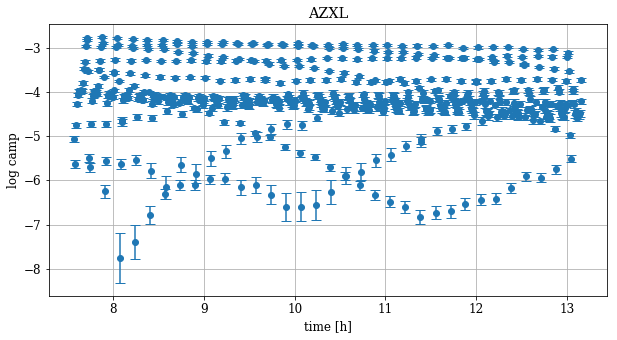

In [6]:
#just errorplot of timeseries
tser_sim.plot(line=False,errorscale=1)

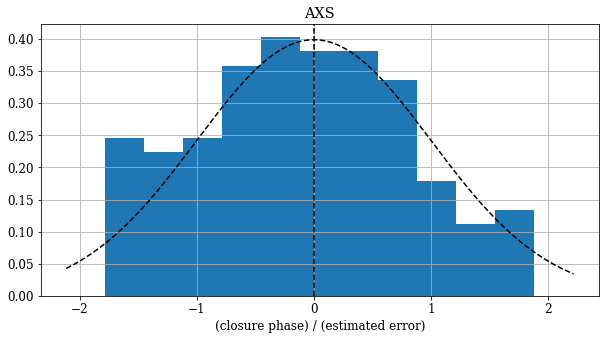

MAD0:  1.01203452699
MEDIAN ABSOLUTE:  1.92623513693
MEDIAN NORMALIZED:  -0.112575453919
MEDIAN ABSOLUTE: -0.226709641673
MEDIAN THERMAL ERROR:  2.21431725217
VARIATION:  3.11051394958


In [7]:
#just histogram of eht data timeseries
#it's a trivial triangle so it's fine to show it:)
tser_eht.hist()

## Saving csv file

use save_csv() to save a text file with your timeseries. By default (columns='default') exported data is mjd, amplitude / cphase / log camplitude, error, but you can export any column from tser.data dataframe.

In [8]:
#example of columns in tser_sim.data, which is of lcamp type, 
#u,v are locations of baselines in uv plane
tser_sim.data.columns

Index(['time', 'datetime', 'mjd', 'u1', 'v1', 'vis1', 'snr1', 'u2', 'v2',
       'vis2', 'snr2', 'u3', 'v3', 'vis3', 'snr3', 'u4', 'v4', 'vis4', 'snr4',
       'lcamp', 'sigmaLCA'],
      dtype='object')

In [9]:
#export csv file
tser_sim.save_csv('test_AZXL.csv',columns='default',sep=',',header=False)

#now read the file with pandas and take a look
foo = pd.read_csv('test_AZXL.csv',names=['time','quantity','error'])
foo.head()

,time,quantity,error
0,58230.315462,-5.069474,0.063122
1,58230.315869,-5.636440,0.084419
2,58230.316276,-4.759159,0.064235
3,58230.316683,-4.278932,0.051418
4,58230.317090,-4.064146,0.045643


## Saving ALL time series that can be extracted from uvfits

It will be an attribute of tobsdata in the future. Specify path to uvfits (pathf)
You can specify if you want closure phases 'CP', log camplitudes 'LCA' or visibility amplitudes 'AMP' or list of some products, specify how many datapoints at least do you want (min_elem), how much do you want to integrate (cadence, which is the same as tcoh [seconds])

In [10]:
#path to your uvfits file
path_data=path_sim

#where to put generated set of files
path_out='./tseries_set/'

#special name at the begining of file
special_name='sim_with_parameters_X_Y_Z'

#what quantity do you want to unpack
get_what=['LCA','CP']

#get pol
#None will give you default component (Stokes I)
#but you can do list of

timed.save_all_products(path_data,path_out,special_name,get_what=get_what,get_pol=None,min_elem=100.,cadence=-1)

Loading uvfits:  /Users/mwielgus/Dropbox (Smithsonian External)/Shared/EHT/TDWG/DataGeneration/TD_EHT/data/generated/continuous_diff_periods_vexA/0.1noise/data_10min_1noise_1ratio/data_10.000min_1.00noise_1.00ratio.uvfits
no IF in uvfits header!
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Saving closure phase time series...
Saving log closure amplitude time series...
